In [106]:
import cv2
import os
import numpy as np
import pandas as pd
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd="/home/aman/anaconda3/envs/tallyInvoiceParser.env/bin/tesseract"
os.environ['TESSDATA_PREFIX'] = "/home/aman/anaconda3/envs/tallyInvoiceParser.env/share/tessdata"
os.environ['MLIR_CRASH_REPRODUCER_DIRECTORY']='tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269'
import import_ipynb
from imagePreProcessor import *
import math
from sklearn.model_selection import train_test_split
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, ReLU, activation, Dropout
import tensorflow as tf
import datefinder
import dateparser
from sklearn.utils import shuffle

In [107]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset'

In [108]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset/')

In [109]:
df = pd.read_csv("tesseract2.csv")

In [110]:
df.drop_duplicates(subset=["x", "y", "imageName"], keep="first", inplace=True)

In [111]:
df.shape

(195, 37)

In [112]:
df.describe()

,Unnamed: 0,left,top,width,height,conf,x,y,PageHeight,PageWidth,...,issue,invoice date,invoice dt,due date,payment due date,ack date,ack dt,contextPresent,contextDist,output
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.112821,1203.600000,1203.687179,198.343590,32.451282,82.320841,1401.943590,1236.138462,3482.369231,2576.343590,...,39.123246,474.848404,603.902233,59.124071,4.728661,28.254367,97.891474,0.610256,535.361837,0.323077
std,87.394517,735.950927,782.358165,89.033064,7.848530,20.195334,730.810341,782.563371,500.880644,328.723664,...,198.403934,754.822983,744.422758,276.612378,46.574005,219.319586,462.162178,0.488947,624.842203,0.468856
min,0.000000,75.000000,67.000000,98.000000,16.000000,0.000000,210.000000,97.000000,1566.000000,1134.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,77.500000,555.500000,607.500000,156.000000,27.500000,74.643830,783.500000,635.500000,3300.000000,2479.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,155.000000,1232.000000,959.000000,182.000000,32.000000,90.819194,1415.000000,985.000000,3500.000000,2481.000000,...,0.000000,0.000000,429.516007,0.000000,0.000000,0.000000,0.000000,1.000000,392.081624,0.000000
75%,231.000000,1871.000000,1558.500000,211.000000,37.000000,96.236962,2104.500000,1598.500000,3508.000000,2550.000000,...,0.000000,596.505151,805.206614,0.000000,0.000000,0.000000,0.000000,1.000000,758.571239,1.000000
max,298.000000,3130.000000,3395.000000,821.000000,71.000000,96.945030,3278.000000,3424.000000,5313.000000,3542.000000,...,1361.009184,3226.750998,3226.750998,2075.708313,466.000000,2156.320013,2875.171125,1.000000,2614.345999,1.000000


In [113]:
len(df["imageName"].unique())

72

In [114]:
def preProcess(df):
    for index in df.index:
        
        x = df["x"][index]
        y = df["y"][index]
        X = df["PageWidth"][index]
        X = X/2
        Y = df["PageHeight"][index]
        Y = Y/2
        
        if x<X:
            df["isLeft"][index]=1
        elif x>=X:
            df["isRight"][index]=1
            
        if y>Y:
            df["isBottom"][index]=1
        elif y<Y:
            df["isTop"][index]=1
    
    for imageName in df["imageName"].unique():
        M = max(df[df["imageName"]==imageName]["contextDist"].to_numpy())
        for index in df.index:
            if df["imageName"][index]==imageName:
                df["contextDist"][index]/=M
            
    df["x"]/=df["PageWidth"]
    df["y"]/=df["PageHeight"]

    df["conf"]/=100

    neighbourFields = ["date", "dated", "invoice", "inv", "delivery", "order", "due", "payment", "tax", "bill", "receipt", "issue", "invoice date", "invoice dt", "due date", "payment due date", "ack date", "ack dt"]

    for col in neighbourFields:
        df[col]/=4000
    
    colsToDrop = ["Unnamed: 0", "left", "top", "width", "height", "text", "PageHeight", "PageWidth", "imageName"]
    df.drop(columns=colsToDrop, inplace=True)
    

In [115]:
preProcess(df)

/tmp/ipykernel_18990/555105736.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isRight"][index]=1
/tmp/ipykernel_18990/555105736.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isTop"][index]=1
/tmp/ipykernel_18990/555105736.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["isBottom"][index]=1
/tmp/ipykernel_18990/555105736.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [116]:
df.corr()

,conf,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,...,issue,invoice date,invoice dt,due date,payment due date,ack date,ack dt,contextPresent,contextDist,output
conf,1.000000,0.103808,-0.000571,0.068057,-0.068057,0.100700,-0.100700,-0.074292,-0.079474,-0.091468,...,-0.186257,-0.075509,-0.044065,-0.001568,-0.280884,-0.074627,-0.008227,-0.118186,-0.107210,0.050455
x,0.103808,1.000000,-0.173964,0.094407,-0.094407,0.911968,-0.911968,0.167657,0.178837,0.348205,...,0.000415,0.289497,0.323976,0.068503,-0.066087,0.051672,0.045622,0.476384,0.527061,0.274651
y,-0.000571,-0.173964,1.000000,-0.832276,0.832276,-0.155576,0.155576,0.379942,0.392351,0.443900,...,0.177173,0.432009,0.453873,0.115793,-0.081670,0.125399,0.175008,0.030146,0.051015,-0.501660
isTop,0.068057,0.094407,-0.832276,1.000000,-1.000000,0.081924,-0.081924,-0.362064,-0.363262,-0.506325,...,-0.145328,-0.475047,-0.526498,-0.157645,0.054948,-0.223957,-0.308978,-0.154676,-0.260500,0.320457
isBottom,-0.068057,-0.094407,0.832276,-1.000000,1.000000,-0.081924,0.081924,0.362064,0.363262,0.506325,...,0.145328,0.475047,0.526498,0.157645,-0.054948,0.223957,0.308978,0.154676,0.260500,-0.320457
isRight,0.100700,0.911968,-0.155576,0.081924,-0.081924,1.000000,-1.000000,0.168169,0.164716,0.288304,...,0.004894,0.273549,0.296664,0.014197,-0.103370,0.068384,0.150988,0.369857,0.420800,0.263549
isLeft,-0.100700,-0.911968,0.155576,-0.081924,0.081924,-1.000000,1.000000,-0.168169,-0.164716,-0.288304,...,-0.004894,-0.273549,-0.296664,-0.014197,0.103370,-0.068384,-0.150988,-0.369857,-0.420800,-0.263549
date,-0.074292,0.167657,0.379942,-0.362064,0.362064,0.168169,-0.168169,1.000000,0.991087,0.363776,...,0.227780,0.586243,0.506801,0.226855,0.000386,-0.008413,0.508738,0.205569,0.275778,-0.187095
dated,-0.079474,0.178837,0.392351,-0.363262,0.363262,0.164716,-0.164716,0.991087,1.000000,0.359545,...,0.234383,0.567349,0.488301,0.242610,0.003079,-0.005394,0.449308,0.193737,0.290577,-0.191480
invoice,-0.091468,0.348205,0.443900,-0.506325,0.506325,0.288304,-0.288304,0.363776,0.359545,1.000000,...,0.125963,0.717882,0.926499,0.125983,0.013586,0.095171,0.247522,0.691342,0.641929,-0.097660


In [117]:
df.dropna(inplace=True)
df.drop(columns=["receipt", "payment due date", "issue", "conf"], inplace=True)

In [118]:
df.describe()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,inv,...,tax,bill,invoice date,invoice dt,due date,ack date,ack dt,contextPresent,contextDist,output
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,...,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,0.583935,0.365223,0.763158,0.236842,0.565789,0.434211,0.114407,0.109755,0.173485,0.049332,...,0.182465,0.092597,0.152295,0.193686,0.018962,0.009062,0.031396,0.782895,0.628148,0.342105
std,0.265148,0.229225,0.426550,0.426550,0.497291,0.497291,0.147777,0.140137,0.157718,0.125623,...,0.191054,0.183153,0.201499,0.190187,0.077873,0.062002,0.130124,0.413638,0.416031,0.475983
min,0.059795,0.019529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.365478,0.188640,1.000000,0.000000,0.000000,0.000000,0.026863,0.022578,0.071188,0.000000,...,0.000000,0.000000,0.000000,0.074171,0.000000,0.000000,0.000000,1.000000,0.221328,0.000000
50%,0.627612,0.281212,1.000000,0.000000,1.000000,0.000000,0.072725,0.070360,0.136326,0.000000,...,0.151676,0.000000,0.096839,0.138808,0.000000,0.000000,0.000000,1.000000,0.852437,0.000000
75%,0.829314,0.478821,1.000000,0.000000,1.000000,1.000000,0.133367,0.129056,0.237441,0.000000,...,0.274188,0.089724,0.182596,0.273990,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,0.941556,0.970979,1.000000,1.000000,1.000000,1.000000,0.708825,0.638026,0.653586,0.709677,...,0.692847,0.749505,0.806688,0.806688,0.518927,0.539080,0.718793,1.000000,1.000000,1.000000


In [119]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,inv,...,tax,bill,invoice date,invoice dt,due date,ack date,ack dt,contextPresent,contextDist,output
x,1.000000,-0.154213,0.045463,-0.045463,0.906069,-0.906069,0.191910,0.212276,0.298918,0.122606,...,0.268239,0.221547,0.250203,0.272292,0.045005,0.039343,0.018049,0.471043,0.527061,0.301161
y,-0.154213,1.000000,-0.858842,0.858842,-0.132283,0.132283,0.345528,0.360060,0.502985,0.436555,...,0.443465,0.269321,0.470668,0.509734,0.117732,0.131256,0.182582,-0.025787,0.051015,-0.503336
isTop,0.045463,-0.858842,1.000000,-1.000000,0.042723,-0.042723,-0.382492,-0.385584,-0.605999,-0.447054,...,-0.503558,-0.354111,-0.541585,-0.623399,-0.170272,-0.246131,-0.339924,-0.180759,-0.260500,0.336484
isBottom,-0.045463,0.858842,-1.000000,1.000000,-0.042723,0.042723,0.382492,0.385584,0.605999,0.447054,...,0.503558,0.354111,0.541585,0.623399,0.170272,0.246131,0.339924,0.180759,0.260500,-0.336484
isRight,0.906069,-0.132283,0.042723,-0.042723,1.000000,-1.000000,0.207794,0.209020,0.241618,0.012238,...,0.276828,0.248727,0.242855,0.256153,-0.012311,0.061123,0.145232,0.343557,0.420800,0.268002
isLeft,-0.906069,0.132283,-0.042723,0.042723,-1.000000,1.000000,-0.207794,-0.209020,-0.241618,-0.012238,...,-0.276828,-0.248727,-0.242855,-0.256153,0.012311,-0.061123,-0.145232,-0.343557,-0.420800,-0.268002
date,0.191910,0.345528,-0.382492,0.382492,0.207794,-0.207794,1.000000,0.989289,0.415531,0.213414,...,0.360615,0.333201,0.663241,0.587312,0.244552,-0.014479,0.559058,0.238845,0.275778,-0.164120
dated,0.212276,0.360060,-0.385584,0.385584,0.209020,-0.209020,0.989289,1.000000,0.420502,0.238173,...,0.349619,0.315585,0.651458,0.575812,0.266023,-0.010383,0.498826,0.234324,0.290577,-0.166781
invoice,0.298918,0.502985,-0.605999,0.605999,0.241618,-0.241618,0.415531,0.420502,1.000000,0.240464,...,0.548451,0.269571,0.673750,0.908770,0.083371,0.071760,0.221671,0.581160,0.641929,-0.167075
inv,0.122606,0.436555,-0.447054,0.447054,0.012238,-0.012238,0.213414,0.238173,0.240464,1.000000,...,0.217840,0.319116,0.405978,0.247730,0.234528,0.113602,-0.028948,0.091439,0.094940,-0.142711


In [120]:
df.shape

(152, 24)

In [121]:
len(df[df["output"]==0])

100

In [122]:
len(df[df["output"]==1])

52

In [123]:
dfTrue = df[df["output"]==1].sample(frac=1)[:52]
dfFalse = df[df["output"]==0].sample(frac=1)[:52]
df = pd.concat([dfTrue, dfFalse], axis=0).sample(frac=1)
df


,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,inv,...,tax,bill,invoice date,invoice dt,due date,ack date,ack dt,contextPresent,contextDist,output
131,0.870617,0.168757,1,0,1,0,0.143500,0.143500,0.186315,0.000000,...,0.000000,0.00000,0.186315,0.186315,0.000000,0.0,0.000000,1,1.000000,1
197,0.762404,0.071266,1,0,1,0,0.029678,0.029678,0.151673,0.000000,...,0.197783,0.00000,0.151673,0.151673,0.000000,0.0,0.000000,1,1.000000,1
286,0.927419,0.501710,0,1,1,0,0.069000,0.069000,0.097512,0.092000,...,0.469665,0.00000,0.071766,0.121497,0.000000,0.0,0.000000,1,1.000000,1
204,0.824314,0.238000,1,0,1,0,0.125190,0.125190,0.150404,0.000000,...,0.203135,0.00000,0.150404,0.150404,0.000000,0.0,0.000000,1,0.789104,0
173,0.110401,0.415758,1,0,0,1,0.051338,0.051338,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,0.562112,0.172596,1,0,1,0,0.203029,0.024405,0.194810,0.000000,...,0.110781,0.00000,0.207648,0.207648,0.000000,0.0,0.224683,1,0.460098,1
129,0.205159,0.396807,1,0,0,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0,0.000000,0
79,0.679954,0.321119,1,0,1,0,0.067767,0.067767,0.335001,0.000000,...,0.611311,0.00000,0.576436,0.576436,0.000000,0.0,0.000000,1,0.512558,0
0,0.772892,0.081050,1,0,1,0,0.029577,0.029577,0.172026,0.000000,...,0.217726,0.00000,0.172026,0.172026,0.000000,0.0,0.000000,1,1.000000,1


In [124]:
df = shuffle(df, random_state=2)

In [125]:
df

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,inv,...,tax,bill,invoice date,invoice dt,due date,ack date,ack dt,contextPresent,contextDist,output
101,0.830980,0.303333,1,0,1,0,0.058500,0.058500,0.082983,0.335563,...,0.125093,0.442738,0.334894,0.334894,0.000,0.000000,0.000000,1,0.199563,1
3,0.719645,0.561358,0,1,1,0,0.066412,0.066412,0.262416,0.133353,...,0.512266,0.403604,0.000000,0.262416,0.000,0.524811,0.524811,1,0.973811,0
207,0.292860,0.224030,1,0,0,1,0.104250,0.000000,0.076448,0.000000,...,0.115726,0.000000,0.076448,0.076448,0.000,0.000000,0.000000,1,0.265869,0
53,0.895204,0.202395,1,0,1,0,0.000000,0.000000,0.234588,0.000000,...,0.271029,0.000000,0.000000,0.234588,0.000,0.000000,0.000000,1,1.000000,1
45,0.399492,0.124976,1,0,0,1,0.000000,0.000000,0.000000,0.000000,...,0.127390,0.000000,0.000000,0.000000,0.000,0.000000,0.071028,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,0.909020,0.375455,1,0,1,0,0.000000,0.000000,0.388302,0.000000,...,0.419720,0.000000,0.000000,0.388302,0.000,0.000000,0.000000,1,1.000000,1
55,0.406288,0.451539,1,0,0,1,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0,0.000000,0
164,0.927843,0.827273,0,1,1,0,0.266259,0.266259,0.515302,0.388856,...,0.274201,0.072708,0.515302,0.515302,0.000,0.000000,0.000000,1,1.000000,0
231,0.337767,0.200741,1,0,0,1,0.144652,0.144652,0.167416,0.000000,...,0.000000,0.000000,0.147849,0.147849,0.157,0.000000,0.000000,1,0.279612,0


In [126]:
df.corr()

,x,y,isTop,isBottom,isRight,isLeft,date,dated,invoice,inv,...,tax,bill,invoice date,invoice dt,due date,ack date,ack dt,contextPresent,contextDist,output
x,1.000000,-0.236697,0.078781,-0.078781,0.920389,-0.920389,0.143760,0.167839,0.290108,0.119070,...,0.285837,0.205937,0.243230,0.273001,0.015822,0.036342,-0.004001,0.432201,0.541253,0.368885
y,-0.236697,1.000000,-0.853109,0.853109,-0.226415,0.226415,0.373929,0.392160,0.350759,0.563824,...,0.448065,0.252725,0.386508,0.371539,0.171320,0.133767,0.135628,-0.146508,-0.087143,-0.564292
isTop,0.078781,-0.853109,1.000000,-1.000000,0.098797,-0.098797,-0.426519,-0.437247,-0.446220,-0.605566,...,-0.471819,-0.327335,-0.454154,-0.470648,-0.242848,-0.238681,-0.269964,-0.041283,-0.140686,0.373254
isBottom,-0.078781,0.853109,-1.000000,1.000000,-0.098797,0.098797,0.426519,0.437247,0.446220,0.605566,...,0.471819,0.327335,0.454154,0.470648,0.242848,0.238681,0.269964,0.041283,0.140686,-0.373254
isRight,0.920389,-0.226415,0.098797,-0.098797,1.000000,-1.000000,0.125108,0.128944,0.232812,0.036528,...,0.252270,0.186611,0.211528,0.237279,0.003055,0.065526,0.082512,0.322888,0.452117,0.350325
isLeft,-0.920389,0.226415,-0.098797,0.098797,-1.000000,1.000000,-0.125108,-0.128944,-0.232812,-0.036528,...,-0.252270,-0.186611,-0.211528,-0.237279,-0.003055,-0.065526,-0.082512,-0.322888,-0.452117,-0.350325
date,0.143760,0.373929,-0.426519,0.426519,0.125108,-0.125108,1.000000,0.982493,0.357643,0.383908,...,0.239875,0.295919,0.641000,0.467663,0.444873,0.023600,0.354023,0.194913,0.188203,-0.146204
dated,0.167839,0.392160,-0.437247,0.437247,0.128944,-0.128944,0.982493,1.000000,0.361028,0.407632,...,0.239746,0.292649,0.631121,0.460692,0.463524,0.028302,0.282935,0.182087,0.207320,-0.141496
invoice,0.290108,0.350759,-0.446220,0.446220,0.232812,-0.232812,0.357643,0.361028,1.000000,0.331310,...,0.552043,0.255486,0.623907,0.933225,0.172786,0.071980,0.149859,0.538710,0.593524,-0.158017
inv,0.119070,0.563824,-0.605566,0.605566,0.036528,-0.036528,0.383908,0.407632,0.331310,1.000000,...,0.309025,0.505100,0.568028,0.338411,0.244448,0.084314,-0.008309,0.105017,0.125168,-0.197954


In [127]:
def extractData(df):
    train, test = train_test_split(df, test_size=0.2, stratify=df["output"], shuffle=True)
    xTrain = train.drop(columns = ["output"]).to_numpy()
    xTest = test.drop(columns = ["output"]).to_numpy()
    yTrain = train["output"].to_numpy()
    yTest = test["output"].to_numpy()
    return xTrain, yTrain, xTest, yTest

In [128]:
xTrain, yTrain, xTest, yTest = extractData(df)

In [129]:
xTrain.shape

(83, 23)

In [130]:
xTest.shape

(21, 23)

In [131]:
yTrain.shape

(83,)

In [132]:
yTest.shape

(21,)

In [133]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [134]:
xgb = XGBClassifier(objective = "binary:hinge", eval_metric = "error")

In [135]:
xgb.fit(xTrain, yTrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:hinge', predictor=None, ...)

In [136]:
pred = xgb.predict(xTest)
pred

array([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1])

In [137]:
yTest

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1])

In [138]:
acc = accuracy_score(pred, yTest)
acc

0.8571428571428571

In [139]:
X = [x for x in range(len(xTest))]

In [140]:
len(X)

21

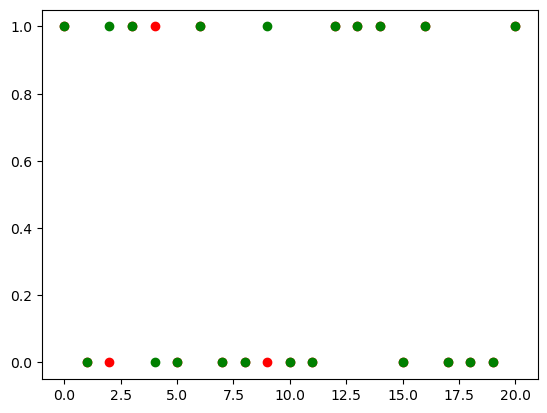

In [141]:
plt.scatter(X, pred, color="red")
plt.scatter(X, yTest, color="green")
plt.show()

In [142]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [143]:
from sklearn.model_selection import cross_val_score

In [144]:
def crossVal(classifier, num_splits):
    scores = cross_val_score(classifier, X, y, cv = num_splits)
    print("Accuracy Scores : ", scores)
    print("Mean Accuracy Score : ", scores.mean())

In [145]:
crossVal(xgb, 5)

Accuracy Scores :  [0.85714286 0.9047619  0.85714286 0.71428571 0.75      ]
Mean Accuracy Score :  0.8166666666666668


In [152]:
params = {
    "n_estimators" : [50, 100, 150, 200],
    "max_depth" : [3, 2, 1],
    "learning_rate" : [0.07, 0.06, 0.05, 0.04, 0.03],
    "num_parallel_tree" : [7, 8, 9, 10],
    "reg_alpha" : [0.5, 0.6, 0.7, 0.8,0.9,],
    "reg_lambda" : [0.5, 0.6, 0.7, 0.8]
}

In [153]:
from sklearn.model_selection import RandomizedSearchCV

In [160]:
gridXGB = RandomizedSearchCV(xgb, params,n_iter=100, cv=5, n_jobs=1, random_state=42)
gridXGB.fit(xTrain, yTrain)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='error',
                                           feature_types=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_r...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           objective='binary:hinge',
                                           predictor=None, ...),
                   n_iter=100, n_jobs=1,
                   param_distributions={'learning_rate': [0.07, 0.06, 0.05,
                                                          0.04, 0.03],
                                        'max_depth': [3, 2, 1],
                                        'n_estimators': [50, 100, 150, 200],
                                        'num_parallel_tree': [7, 8, 9, 10],
                                        'reg_alpha': [0.5, 0.6, 0.7, 0.8, 0.9],
                                        'reg_lambda': [0.5, 0.6, 0.7, 0.8]},
                   random_state=42)

In [161]:
bestModel = gridXGB.best_estimator_
bestModel

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=7,
              objective='binary:hinge', predictor=None, ...)

In [162]:
bestParams = gridXGB.best_params_
bestParams

{'reg_lambda': 0.7,
 'reg_alpha': 0.9,
 'num_parallel_tree': 7,
 'n_estimators': 200,
 'max_depth': 2,
 'learning_rate': 0.06}

In [163]:
yPred = bestModel.predict(xTest)

In [164]:
print(accuracy_score(yPred, yTest))

0.9523809523809523


In [173]:
crossVal(bestModel, 3)

Accuracy Scores :  [0.88571429 0.85714286 0.85294118]
Mean Accuracy Score :  0.8652661064425771


In [174]:
bestModel.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=7,
              objective='binary:hinge', predictor=None, ...)

In [176]:
crossVal(bestModel, 3)

Accuracy Scores :  [0.88571429 0.85714286 0.85294118]
Mean Accuracy Score :  0.8652661064425771


In [177]:
bestModel.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=7,
              objective='binary:hinge', predictor=None, ...)>

In [179]:
bestCLF = XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=7,
              objective='binary:hinge')

In [180]:
bestCLF.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=7,
              objective='binary:hinge', predictor=None, ...)

In [182]:
pred = bestCLF.predict(xTest)

In [183]:
accuracy_score(pred, yTest)

1.0

In [220]:
crossVal(bestCLF, 3)

Accuracy Scores :  [0.88571429 0.85714286 0.82352941]
Mean Accuracy Score :  0.8554621848739495


In [221]:
pwd

'/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Dataset'

In [222]:
os.chdir('/home/aman/Documents/Tally/Git-Document-AI/Document-AI/InvoiceDateModel-v2/Models')

In [224]:
bestCLF.save_model("InvoiceDateXGBoost.json")

In [225]:
model = XGBClassifier()

In [226]:
model.load_model("InvoiceDateXGBoost.json")

In [228]:
pred = model.predict(xTest)
pred

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1])

In [229]:
yTest

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1])

In [232]:
accuracy_score(pred, yTest)

1.0